


# Medical Image Anomaly Detection Project

**Context** :

This dataset contains quantitative features extracted from medical images along with labels indicating whether an anomaly was detected. The features appear to describe various image characteristics that could be useful for identifying abnormalities in medical imaging.

**Features**:

The dataset contains the following columns:

BrightnessMean: Mean brightness level of the image

Contrast: Image contrast measurement

EdgeDensity: Density of edges in the image

Symmetry: Symmetry measurement of the image

ColorVariance: Variance in color/channel values

Modality: Imaging modality (Ultrasound, X-ray, MRI)

AnomalyDetected: Binary label (0=normal, 1=anomaly)

In [228]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [229]:
# Load the dataset
#uploaded = files.upload()

df = pd.read_excel('medical_images.xlsx')

# Display first few rows
print(df.head(10))

   BrightnessMean  Contrast  EdgeDensity  Symmetry  ColorVariance    Modality  \
0            56.0      39.0         48.0      97.0           62.0       X-ray   
1            50.0      67.0         64.0      96.0           46.0  Ultrasound   
2            54.0      44.0         63.0      88.0           63.0         MRI   
3            42.0      54.0         39.0      87.0           53.0       X-ray   
4            40.0      49.0         62.0      87.0           50.0         MRI   
5            53.0      54.0         64.0      86.0           46.0  Ultrasound   
6            55.0      47.0          NaN      85.0          108.0         MRI   
7             NaN      39.0         25.0      85.0            NaN  Ultrasound   
8            69.0      63.0         22.0      84.0           36.0       X-ray   
9            39.0      32.0         32.0      83.0           58.0         MRI   

   AnomalyDetected  
0                0  
1                0  
2                0  
3                0  
4  

# 1-Data exploration

In [230]:
# Basic information about the dataset
print("Dataset shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isnull().sum())

Dataset shape: (1000, 7)

Data types:
 BrightnessMean     float64
Contrast           float64
EdgeDensity        float64
Symmetry           float64
ColorVariance      float64
Modality            object
AnomalyDetected      int64
dtype: object

Missing values per column:
 BrightnessMean     80
Contrast           80
EdgeDensity        80
Symmetry           80
ColorVariance      80
Modality            0
AnomalyDetected     0
dtype: int64


In [231]:

# Descriptive statistics
print("\nDescriptive statistics:\n", df.describe())

# Categorical feature statistics
print("\nModality distribution:")
print(df['Modality'].value_counts())



Descriptive statistics:
        BrightnessMean    Contrast  EdgeDensity    Symmetry  ColorVariance  \
count      920.000000  920.000000   920.000000  920.000000     920.000000   
mean        50.014130   49.335870    49.634783   49.165217      49.842391   
std         14.716132   14.904674    15.039928   14.610537      15.521411   
min          2.000000   -4.000000    12.000000    0.000000       0.000000   
25%         40.000000   39.000000    40.000000   39.750000      40.000000   
50%         50.000000   49.000000    50.000000   49.000000      50.000000   
75%         60.000000   59.000000    60.000000   59.000000      60.000000   
max         95.000000   98.000000    91.000000   97.000000     108.000000   

       AnomalyDetected  
count       1000.00000  
mean           0.10100  
std            0.30148  
min            0.00000  
25%            0.00000  
50%            0.00000  
75%            0.00000  
max            1.00000  

Modality distribution:
Modality
X-ray         350
MRI 

In [232]:

# Check the distribution of the target variable
print("\nAnomaly distribution:\n", df['AnomalyDetected'].value_counts(normalize=True))


Anomaly distribution:
 AnomalyDetected
0    0.899
1    0.101
Name: proportion, dtype: float64


**Data Visualization**


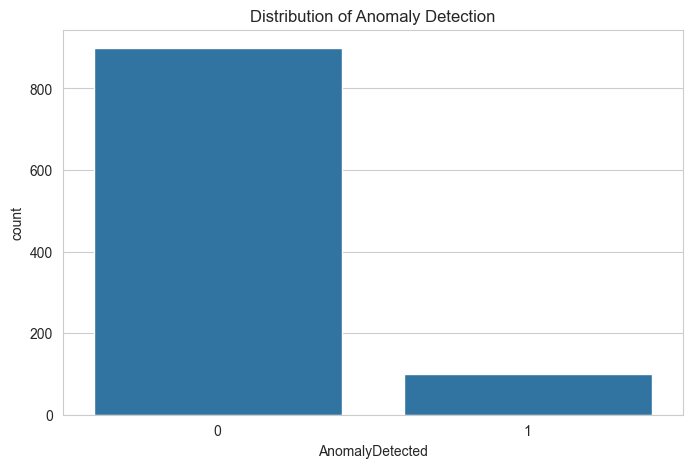

Percentage of anomalies: 10.10%
Percentage of normal images: 89.90%


In [233]:
# Plot target variable distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='AnomalyDetected', data=df)
plt.title('Distribution of Anomaly Detection')
plt.show()

# Calculate percentages
anomaly_perc = df['AnomalyDetected'].value_counts(normalize=True) * 100
print(f"Percentage of anomalies: {anomaly_perc[1]:.2f}%")
print(f"Percentage of normal images: {anomaly_perc[0]:.2f}%")

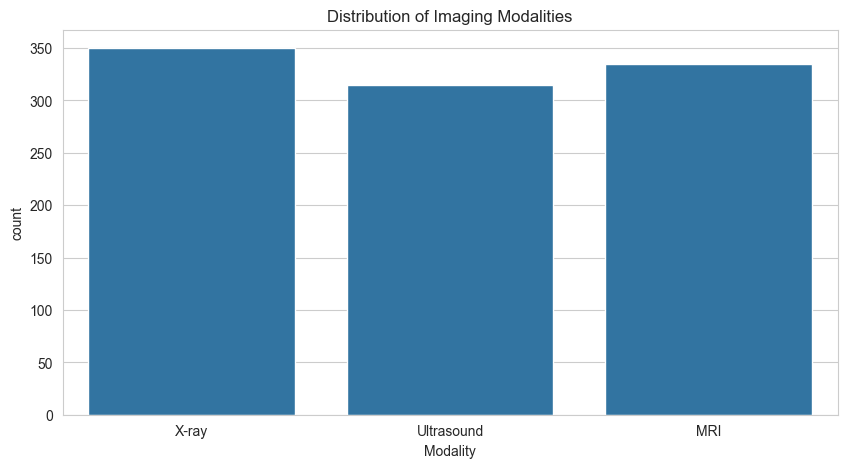

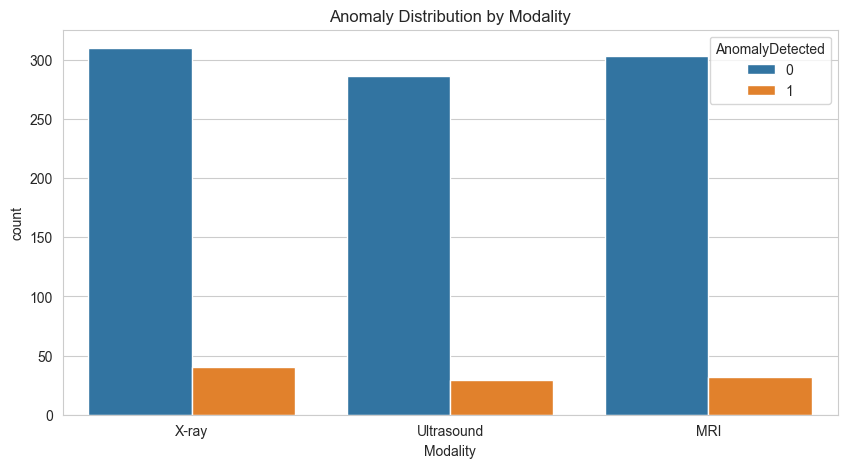

In [234]:
# Plot modality distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='Modality', data=df)
plt.title('Distribution of Imaging Modalities')
plt.show()

# Modality distribution with anomaly
plt.figure(figsize=(10, 5))
sns.countplot(x='Modality', hue='AnomalyDetected', data=df)
plt.title('Anomaly Distribution by Modality')
plt.show()

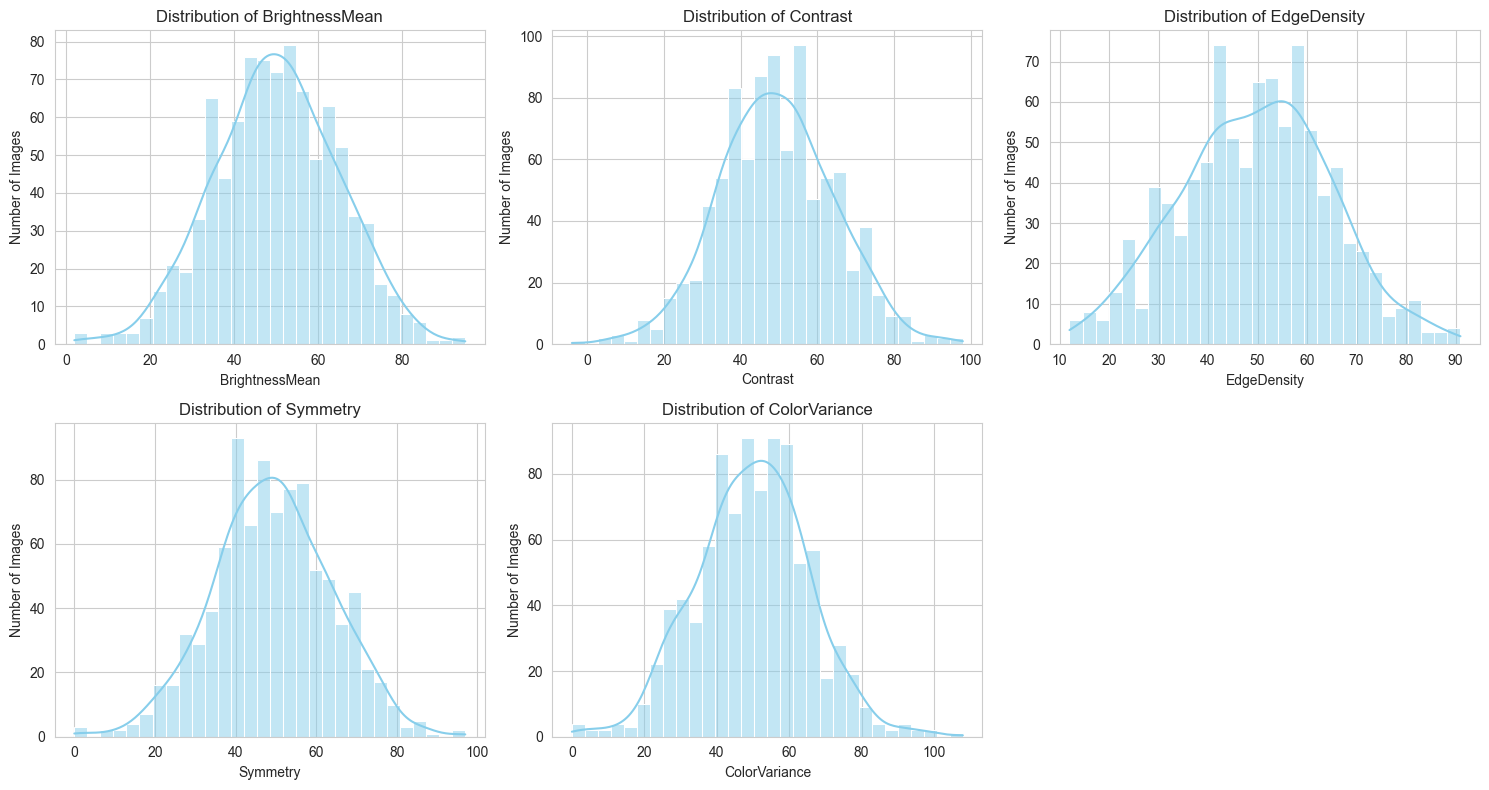

In [235]:
plt.figure(figsize=(15, 8))
numerical_features = ['BrightnessMean', 'Contrast', 'EdgeDensity', 'Symmetry', 'ColorVariance']
# Plot each numerical feature
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)

    # Simple histogram with KDE
    ax = sns.histplot(df[feature], kde=True, bins=30, color='skyblue')

    # Add clear labels
    plt.xlabel(feature)
    plt.ylabel('Number of Images')  # Explicitly label what "count" means
    plt.title(f'Distribution of {feature}')



plt.tight_layout()
plt.show()

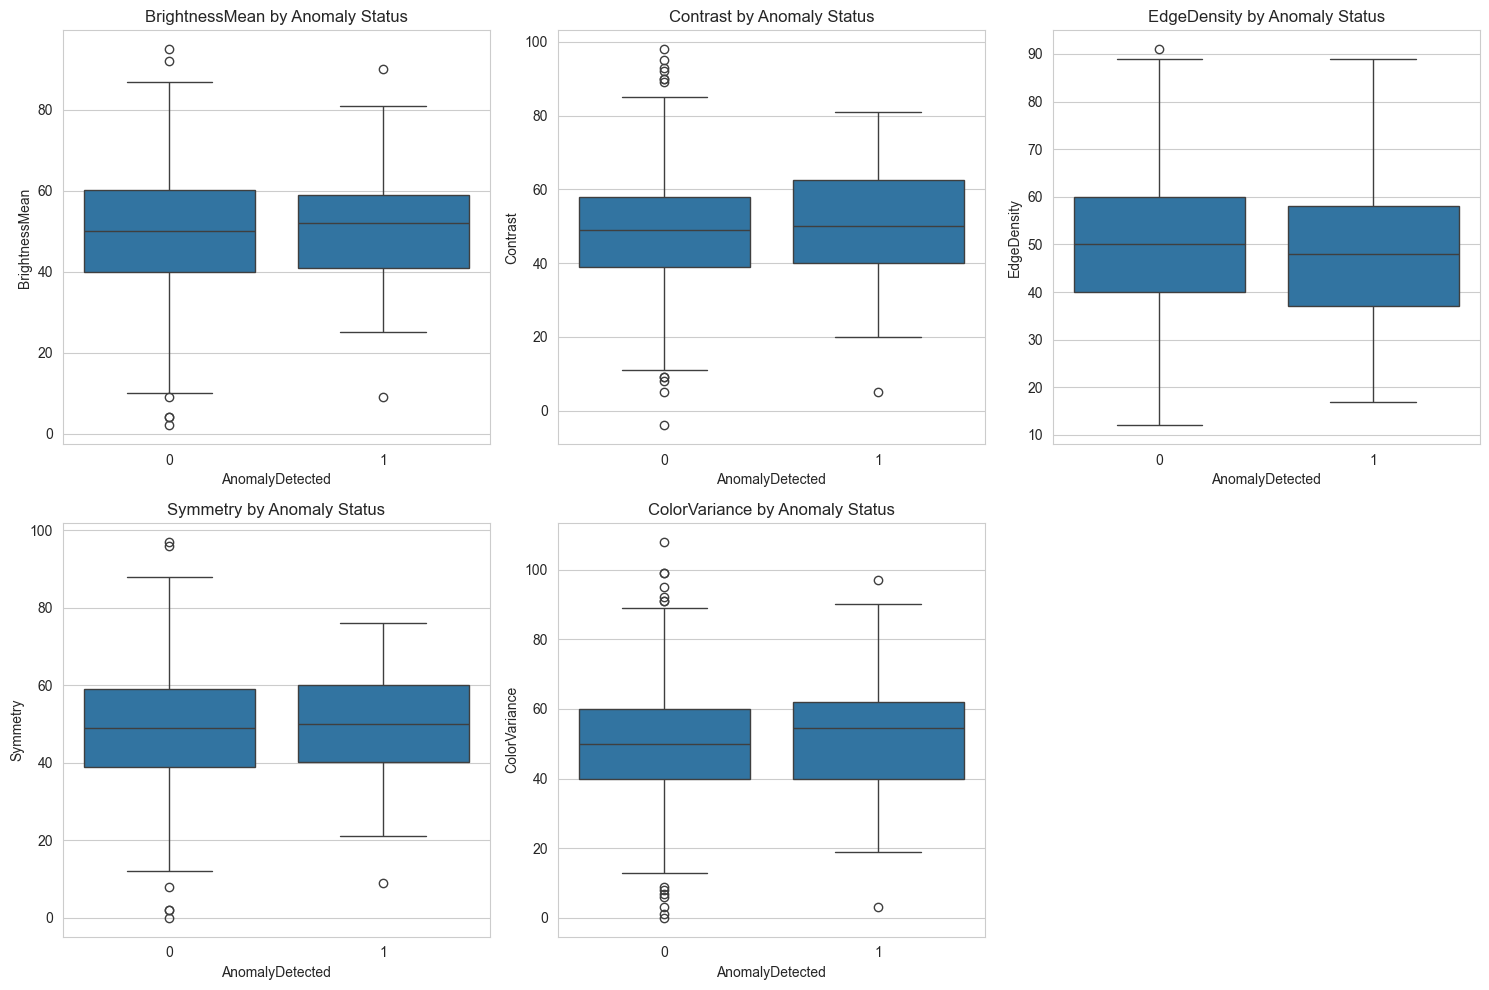

In [236]:
# Boxplots for numerical features by anomaly status
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='AnomalyDetected', y=feature, data=df)
    plt.title(f'{feature} by Anomaly Status')
plt.tight_layout()
plt.show()

# 2. Data Preprocessing


 Detect and Handle Erroneous Values


In [237]:
error_ranges = {
    'BrightnessMean': (0, 100),  # 0-100% intensity range
    'Contrast': (0, 100),        # Negative contrast is impossible
    'EdgeDensity': (0, 100),     # Percentage scale
    'Symmetry': (0, 100),        # 0-100% symmetry
    'ColorVariance': (0, 100)   # No upper limit but can't be negative
}

for feature, (min_val, max_val) in error_ranges.items():
    errors = pd.Series(False, index=df.index)
    if min_val is not None:
        errors |= df[feature] < min_val
    if max_val is not None:
        errors |= df[feature] > max_val
    error_values = df.loc[errors, feature]

    print(f"\n{feature} - {len(error_values)} erroneous value(s) detected:")
    if not error_values.empty:
        print(error_values)



BrightnessMean - 0 erroneous value(s) detected:

Contrast - 1 erroneous value(s) detected:
120   -4.0
Name: Contrast, dtype: float64

EdgeDensity - 0 erroneous value(s) detected:

Symmetry - 0 erroneous value(s) detected:

ColorVariance - 1 erroneous value(s) detected:
6    108.0
Name: ColorVariance, dtype: float64


In [238]:
# Remove rows where Contrast < 0
df_cleaned = df[df['Contrast'].isna() | (df['Contrast'] >= 0)]
#
# Cap ColorVariance to 100
df_cleaned['ColorVariance'] = df_cleaned['ColorVariance'].clip(upper=100)

# Confirm the cleaning
df_cleaned.describe()


C:\Users\user\AppData\Local\Temp\ipykernel_18004\1168367765.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['ColorVariance'] = df_cleaned['ColorVariance'].clip(upper=100)


,BrightnessMean,Contrast,EdgeDensity,Symmetry,ColorVariance,AnomalyDetected
count,919.000000,919.000000,919.000000,919.000000,919.000000,999.000000
mean,50.016322,49.393906,49.628945,49.146899,49.837867,0.101101
std,14.723995,14.808414,15.047075,14.607917,15.498923,0.301614
min,2.000000,5.000000,12.000000,0.000000,0.000000,0.000000
25%,40.000000,39.000000,40.000000,39.500000,40.000000,0.000000
50%,50.000000,49.000000,50.000000,49.000000,50.000000,0.000000
75%,60.000000,59.000000,60.000000,59.000000,60.000000,0.000000
max,95.000000,98.000000,91.000000,97.000000,100.000000,1.000000


 Handling Missing Data


In [239]:
# Check how many missing values exist in each column of df_cleaned
missing_summary = df_cleaned.isnull().sum()
missing_summary[missing_summary > 0]


BrightnessMean    80
Contrast          80
EdgeDensity       80
Symmetry          80
ColorVariance     80
dtype: int64

Grouping by Modality to impute missing values using the median :
* Different modalities (MRI, X-ray, Ultrasound) produce images with very different characteristics.

* For example, brightness or contrast ranges in X-rays may differ significantly from MRI or Ultrasound.

In [240]:
df_imputed=df_cleaned.copy()
for feature in numerical_features:
  df_imputed[feature] = df_imputed.groupby('Modality')[feature].transform(lambda x: x.fillna(x.median()))


In [241]:
df_imputed.isnull().sum()


BrightnessMean     0
Contrast           0
EdgeDensity        0
Symmetry           0
ColorVariance      0
Modality           0
AnomalyDetected    0
dtype: int64

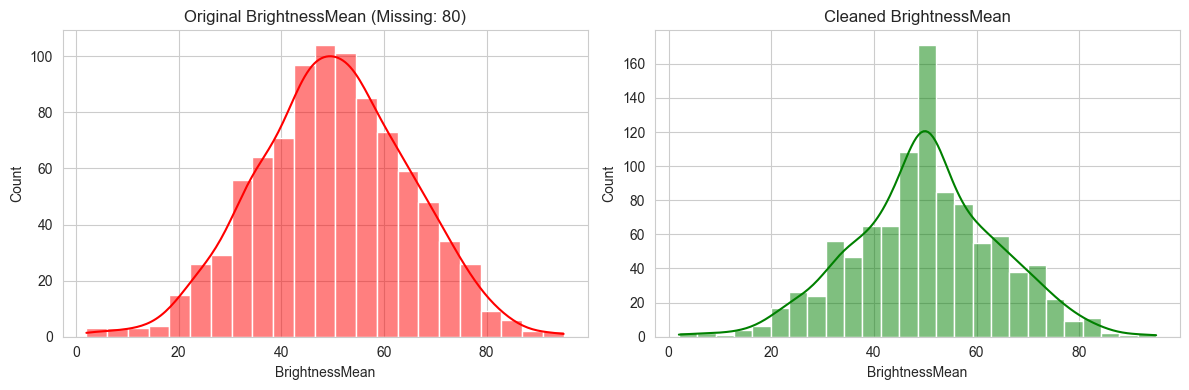

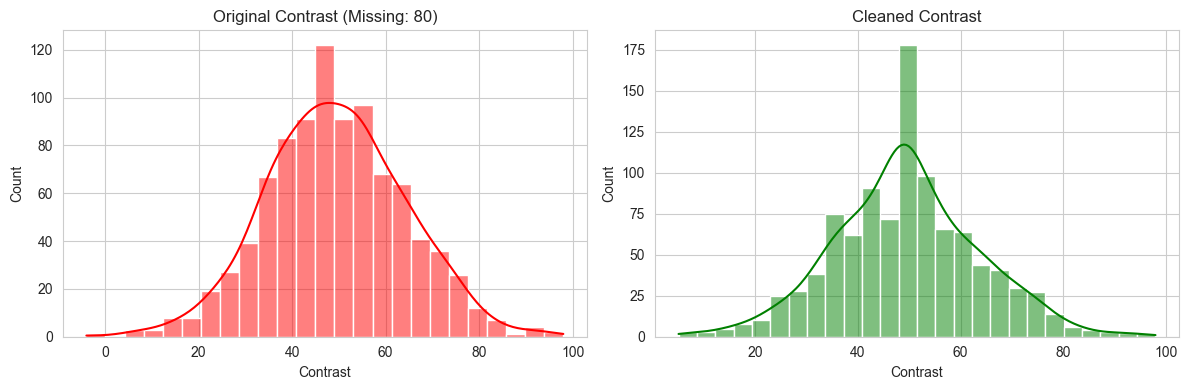

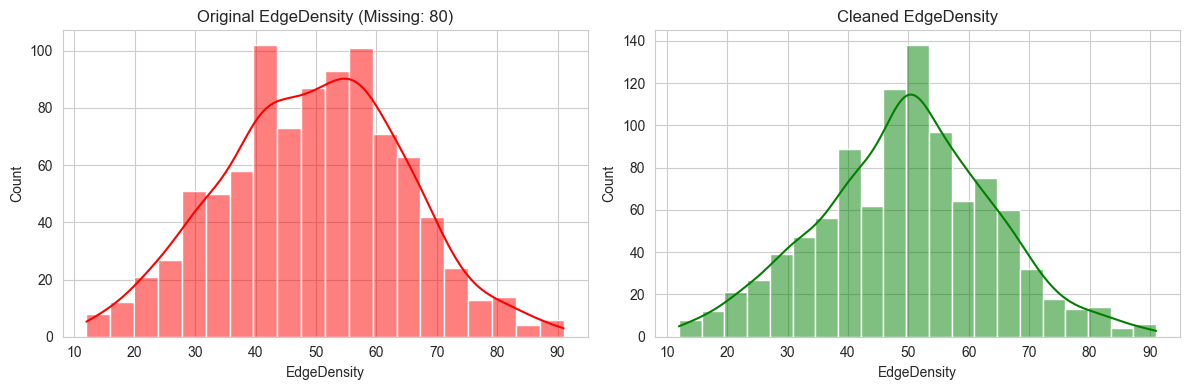

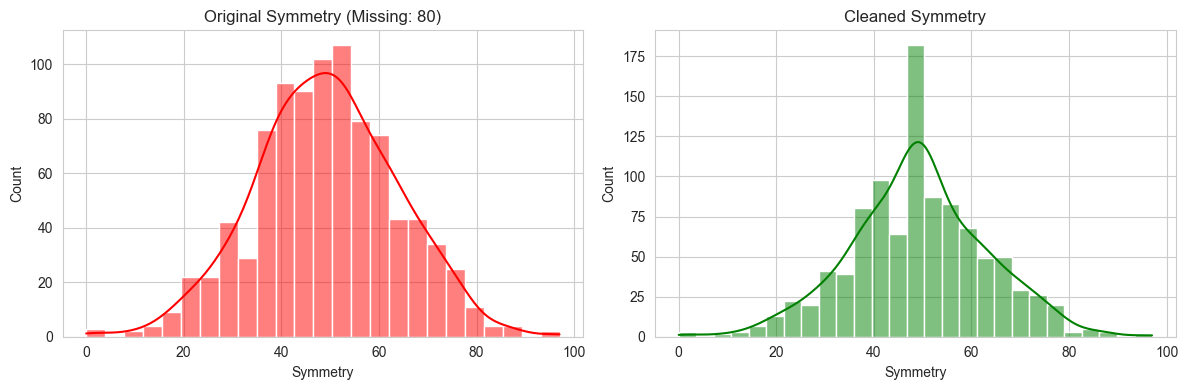

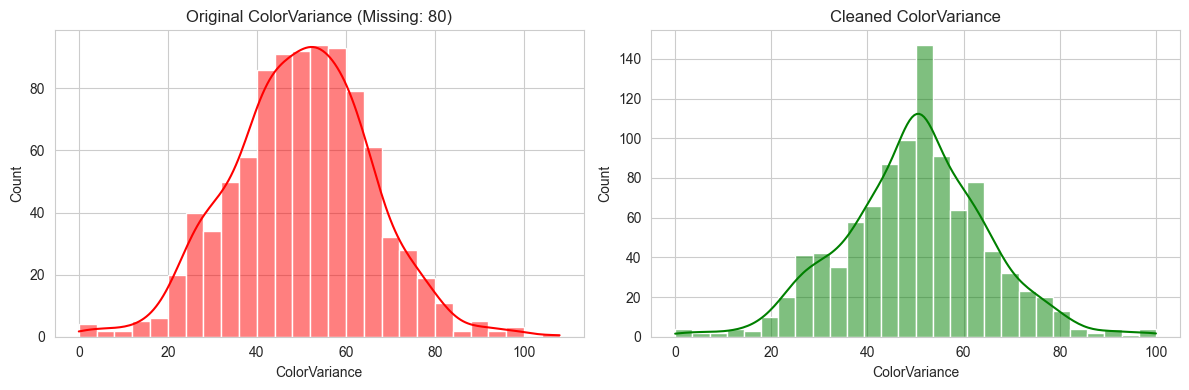

In [242]:
# Validate Imputation Quality
def verify_imputation(df, df_imputed, feature):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True, color='red', label='Original')
    plt.title(f"Original {feature} (Missing: {df[feature].isnull().sum()})")

    plt.subplot(1, 2, 2)
    sns.histplot(df_imputed[feature], kde=True, color='green', label='Imputed')
    plt.title(f"Cleaned {feature}")

    plt.tight_layout()
    plt.show()

for feature in numerical_features:
    if df[feature].isnull().any():
        verify_imputation(df, df_imputed, feature)

Clearly this imputation is not right since there is an artifical spike so i will try to add noise to smooth it

In [243]:
# Create a new DataFrame to perform safe imputation on
df_imputedbynoise = df_cleaned.copy()

# Safe Imputation: Modality-specific median with slight noise
for feature in numerical_features:
    # Compute median per modality
    modality_medians = df_imputedbynoise.groupby('Modality')[feature].median()

    # Generate reproducible noise factors
    np.random.seed(42)
    noise = pd.DataFrame({
        'noise_factor': np.random.uniform(0.98, 1.02, size=len(df_imputedbynoise))
    }, index=df_imputedbynoise.index)

    # Apply noise-augmented median imputation per modality
    for modality in df_imputedbynoise['Modality'].unique():
        mask = (df_imputedbynoise['Modality'] == modality) & (df_imputedbynoise[feature].isna())
        df_imputedbynoise.loc[mask, feature] = (
            modality_medians[modality] * noise.loc[mask, 'noise_factor']
        )


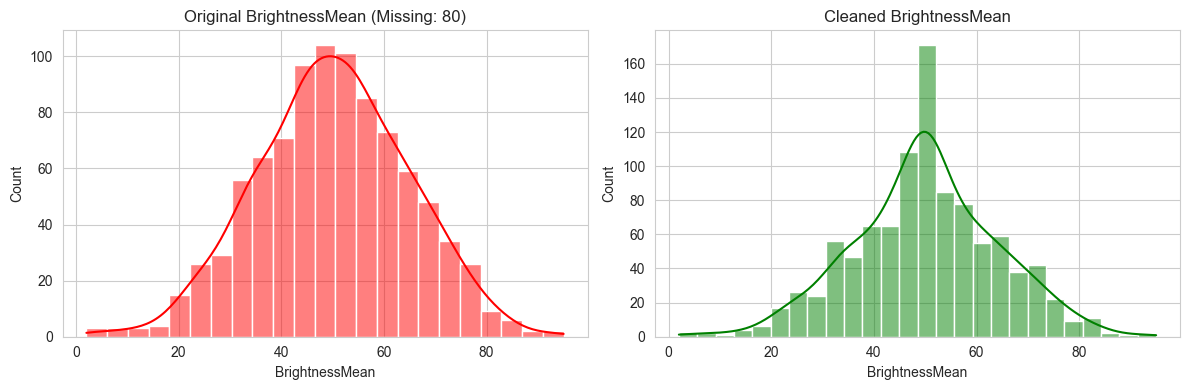

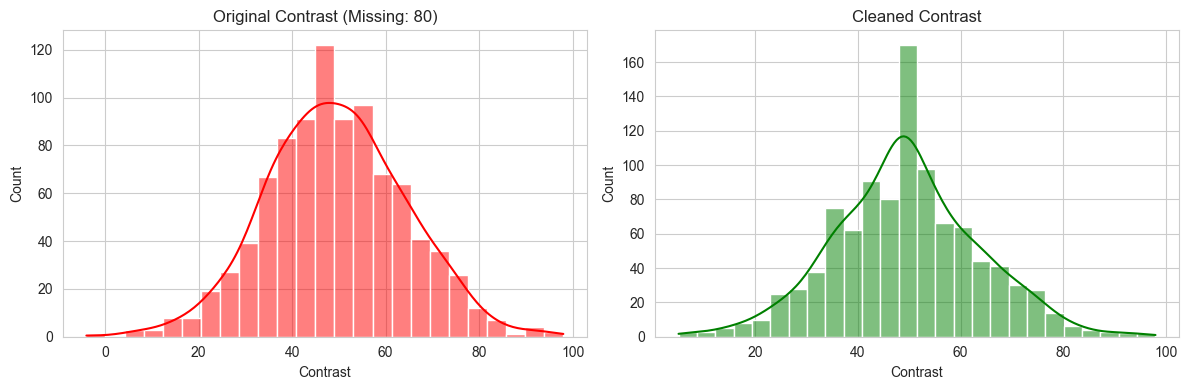

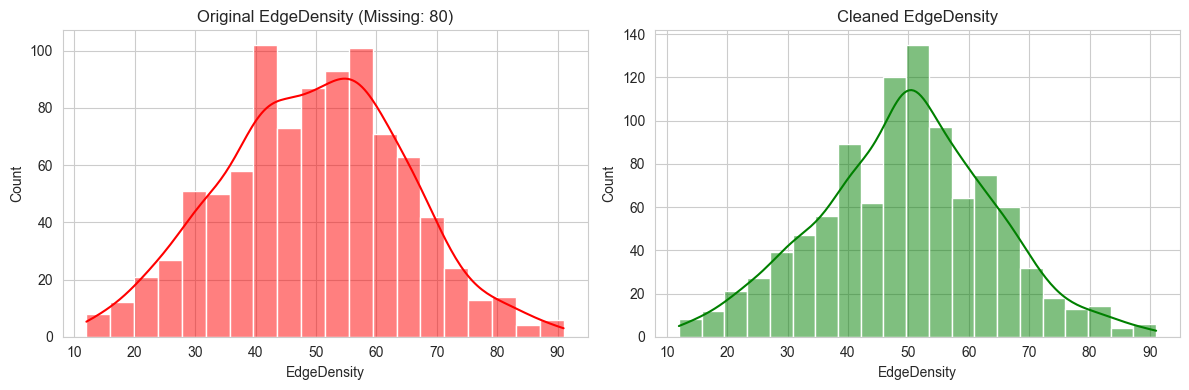

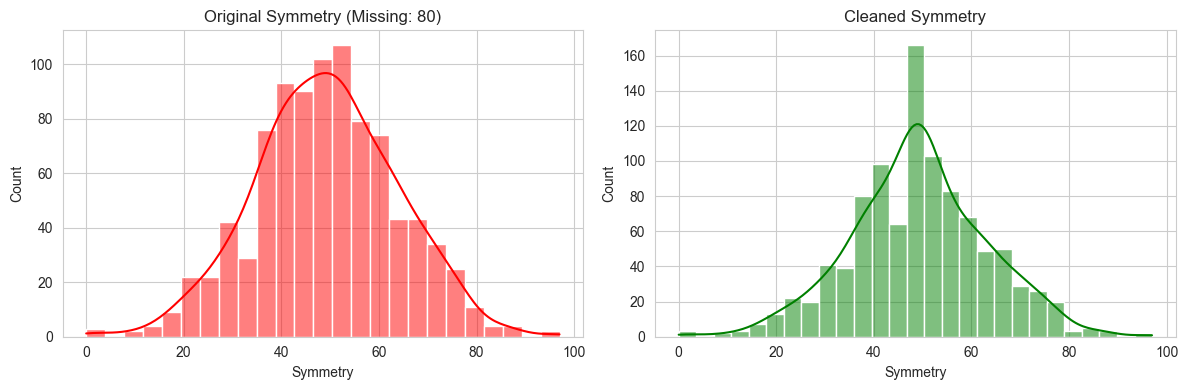

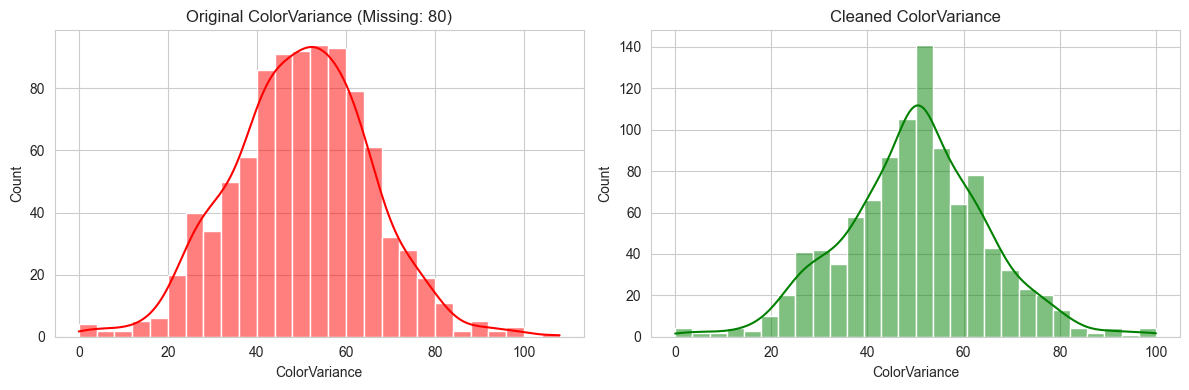

In [244]:
for feature in numerical_features:
    if df[feature].isnull().any():
        verify_imputation(df, df_imputedbynoise, feature)

same problem , SO I will Impute missing numerical values  using KNN, while considering Modality as a contextual feature.

In [245]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder


# Step 1: Copy cleaned dataset
df_imputed_knn = df_cleaned.copy()

# Step 2: Separate numerical and categorical columns
numerical_features = ['BrightnessMean', 'Contrast', 'EdgeDensity', 'Symmetry', 'ColorVariance']
categorical_feature = 'Modality'

# Step 3: One-hot encode Modality (drop='first' to avoid multicollinearity)
encoder = OneHotEncoder(sparse_output=False, drop='first')
modality_encoded = encoder.fit_transform(df_imputed_knn[[categorical_feature]])

# Fix the column names and shape mismatch
modality_encoded_df = pd.DataFrame(
    modality_encoded,
    columns=encoder.get_feature_names_out(),
    index=df_imputed_knn.index
)

# Step 4: Concatenate numerical + encoded categorical
combined = pd.concat([df_imputed_knn[numerical_features], modality_encoded_df], axis=1)

# Step 5: KNN Imputation (k=5 is a common choice)
imputer = KNNImputer(n_neighbors=5)
imputed_array = imputer.fit_transform(combined)

# Step 6: Convert result back to DataFrame
df_imputed_knn[numerical_features] = imputed_array[:, :len(numerical_features)]

# Optional: Confirm no more missing values
print(df_imputed_knn[numerical_features].isnull().sum())


BrightnessMean    0
Contrast          0
EdgeDensity       0
Symmetry          0
ColorVariance     0
dtype: int64


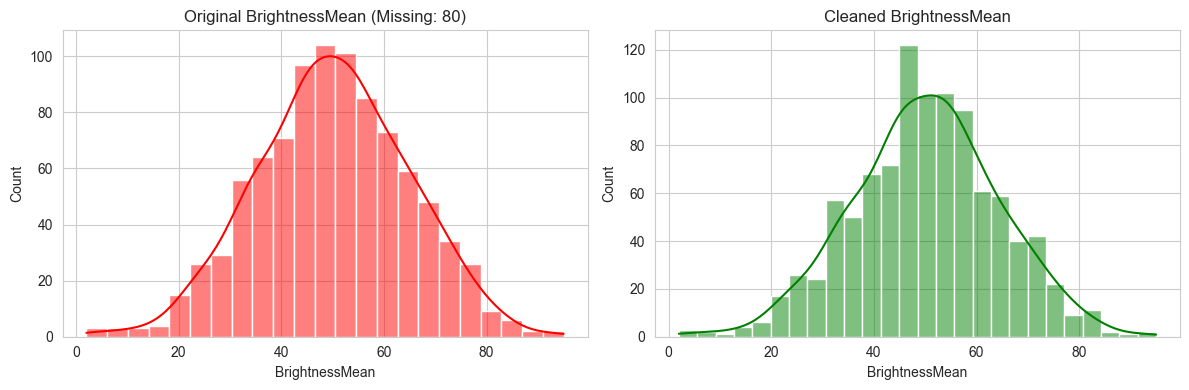

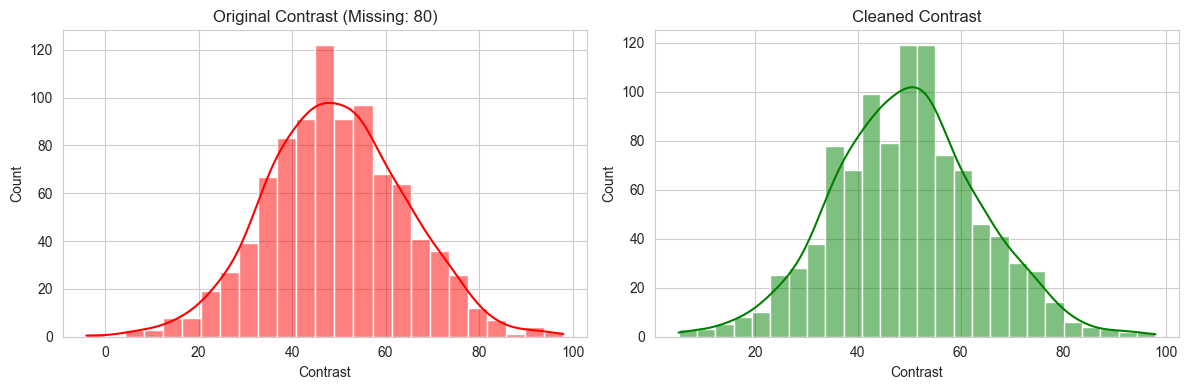

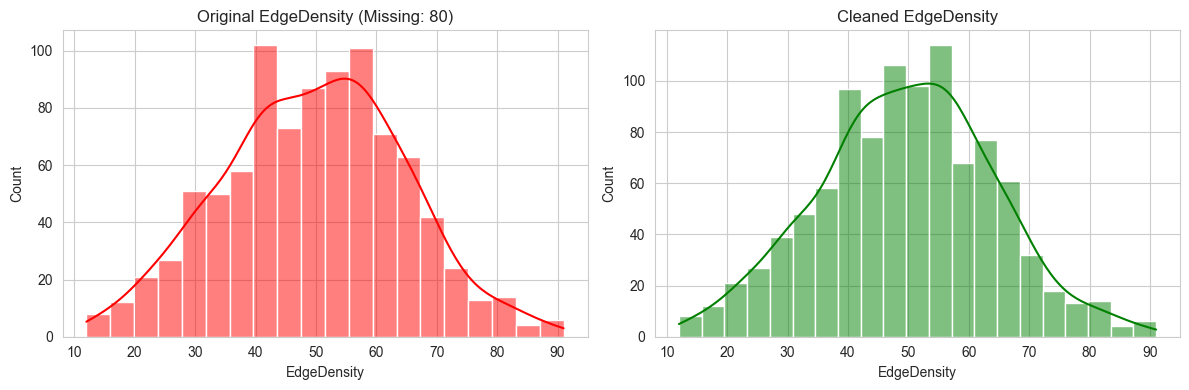

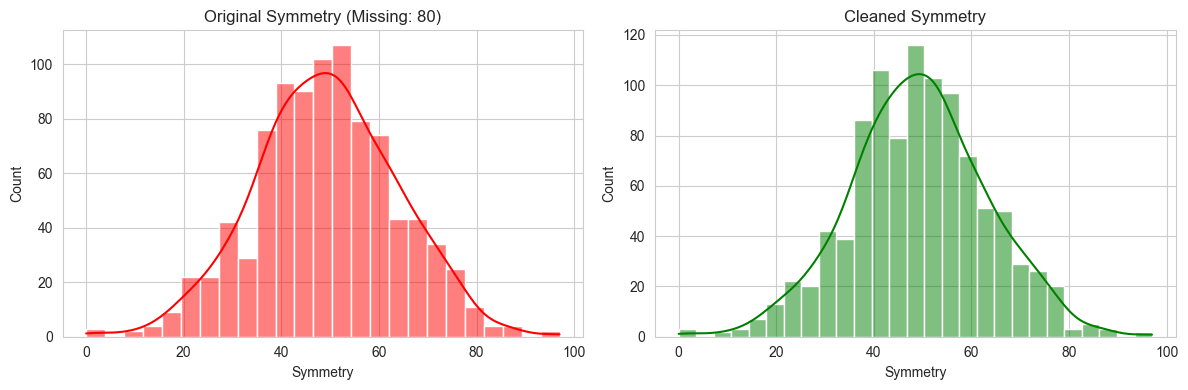

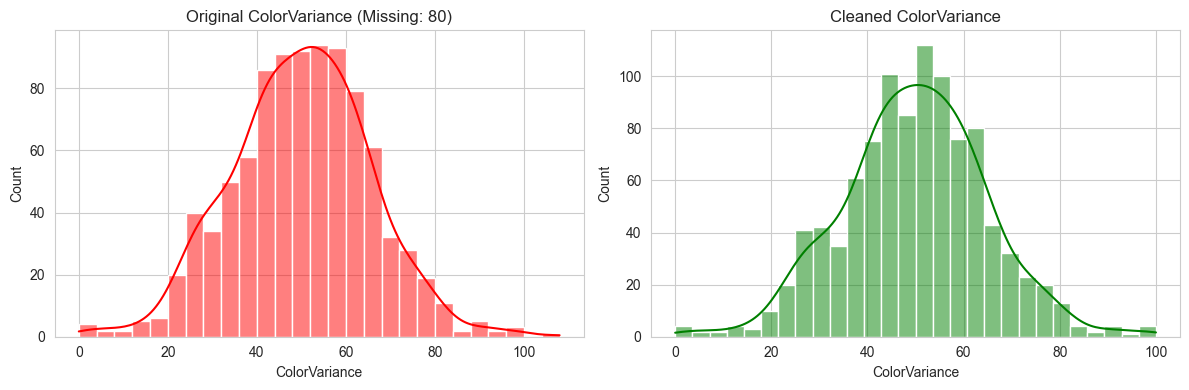

In [246]:
for feature in numerical_features:
    if df[feature].isnull().any():
        verify_imputation(df, df_imputed_knn, feature)

In [247]:
df_imputed_knn.describe()


,BrightnessMean,Contrast,EdgeDensity,Symmetry,ColorVariance,AnomalyDetected
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,50.116116,49.433834,49.602402,49.136336,49.823023,0.101101
std,14.272941,14.316579,14.543931,14.132367,14.969433,0.301614
min,2.000000,5.000000,12.000000,0.000000,0.000000,0.000000
25%,41.000000,40.000000,40.000000,40.000000,41.000000,0.000000
50%,50.000000,49.200000,50.000000,49.000000,50.000000,0.000000
75%,59.100000,58.000000,59.000000,58.000000,59.000000,0.000000
max,95.000000,98.000000,91.000000,97.000000,100.000000,1.000000


In [248]:
print("\nModality distribution:")
print(df_imputed_knn['Modality'].value_counts())


Modality distribution:
Modality
X-ray         350
MRI           334
Ultrasound    315
Name: count, dtype: int64


**Encoding categorical variables (Modality)**


In [249]:
anomaly_rate_per_modality = df_imputed_knn.groupby('Modality')['AnomalyDetected'].mean()
anomaly_rate_per_modality

Modality
MRI           0.095808
Ultrasound    0.092063
X-ray         0.114286
Name: AnomalyDetected, dtype: float64

I tought of using target encoding since the 'modality' strongly influences the target variable but the differences between classes are small , it might cause overfititting later so i will use one hot encoding

In [250]:

# Step 1: Preserve the imputed dataset before encoding
df_final = df_imputed_knn.copy()

# Step 2: Apply One-Hot Encoding on 'Modality'
encoder = OneHotEncoder(sparse_output=False)
modality_encoded = encoder.fit_transform(df_final[['Modality']])

# Step 3: Create a DataFrame for the encoded columns
modality_encoded_df = pd.DataFrame(
    modality_encoded,
    columns=encoder.get_feature_names_out(['Modality']),
    index=df_final.index
)

# Step 4: Drop the original 'Modality' column and add the encoded columns
df_final = df_final.drop(columns='Modality')
df_final = pd.concat([df_final, modality_encoded_df], axis=1)

# Step 5: Confirm changes
print(df_final.head())


   BrightnessMean  Contrast  EdgeDensity  Symmetry  ColorVariance  \
0            56.0      39.0         48.0      97.0           62.0   
1            50.0      67.0         64.0      96.0           46.0   
2            54.0      44.0         63.0      88.0           63.0   
3            42.0      54.0         39.0      87.0           53.0   
4            40.0      49.0         62.0      87.0           50.0   

   AnomalyDetected  Modality_MRI  Modality_Ultrasound  Modality_X-ray  
0                0           0.0                  0.0             1.0  
1                0           0.0                  1.0             0.0  
2                0           1.0                  0.0             0.0  
3                0           0.0                  0.0             1.0  
4                0           1.0                  0.0             0.0  


In [251]:
# Split data into train and test sets Stratified split to preserve anomaly ratio
from sklearn.model_selection import train_test_split
X = df_final.drop(columns=['AnomalyDetected'])
y = df_final['AnomalyDetected']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

**Standardizing data** :


In [252]:
from sklearn.preprocessing import StandardScaler

num_cols = ['BrightnessMean', 'Contrast', 'EdgeDensity', 'Symmetry', 'ColorVariance']
cat_cols = ['Modality_MRI', 'Modality_Ultrasound', 'Modality_X-ray']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])



In [253]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
# Initialize and train on standardized data
modelLogisticRegression = LogisticRegression( class_weight='balanced',random_state=42)
modelLogisticRegression.fit(X_train_scaled, y_train)

# Predict on standardized test data
y_pred = modelLogisticRegression.predict(X_test_scaled)
# Evaluate
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.55      0.69       180
           1       0.11      0.50      0.18        20

    accuracy                           0.55       200
   macro avg       0.51      0.53      0.43       200
weighted avg       0.83      0.55      0.63       200



By default, logistic regression uses a threshold of 0.5. But  i will adjust it because of my  imbalanced data in order to optimize the predections of the class 0


In [254]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# 1. Train the logistic regression model
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# 2. Get predicted probabilities
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# 3. Loop through thresholds and evaluate
thresholds = np.arange(0.1, 1.0, 0.1)

print(f"{'Threshold':<10}{'Precision':<10}{'Recall':<10}{'F1-score':<10}")
print("-" * 40)

for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    print(f"{threshold:<10.2f}{precision:<10.2f}{recall:<10.2f}{f1:<10.2f}")


Threshold Precision Recall    F1-score  
----------------------------------------
0.10      0.10      1.00      0.18      
0.20      0.10      1.00      0.18      
0.30      0.10      1.00      0.18      
0.40      0.10      0.95      0.18      
0.50      0.11      0.50      0.18      
0.60      0.17      0.05      0.08      
0.70      0.00      0.00      0.00      
0.80      0.00      0.00      0.00      
0.90      0.00      0.00      0.00      


Almost Same results for all thresholds, I will Use LogisticRegressionCV for Regularization Tuning

In [255]:
from sklearn.linear_model import LogisticRegressionCV

modelLogisticCV = LogisticRegressionCV(
    cv=5,
    scoring='f1',
    class_weight={0:1,1:900},
    random_state=42,
    max_iter=1000
)
modelLogisticCV.fit(X_train_scaled, y_train)
y_pred = modelLogisticRegression.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.55      0.69       180
           1       0.11      0.50      0.18        20

    accuracy                           0.55       200
   macro avg       0.51      0.53      0.43       200
weighted avg       0.83      0.55      0.63       200



**Analyze the coefficients to understand feature influence**


               Feature  Coefficient                 Effect
7       Modality_X-ray     0.157204  Increase anomaly risk
6  Modality_Ultrasound    -0.138781  Decrease anomaly risk
1             Contrast     0.108688  Increase anomaly risk
2          EdgeDensity    -0.098246  Decrease anomaly risk
4        ColorVariance     0.091006  Increase anomaly risk
3             Symmetry     0.061621  Increase anomaly risk
5         Modality_MRI    -0.037668  Decrease anomaly risk
0       BrightnessMean     0.023390  Increase anomaly risk


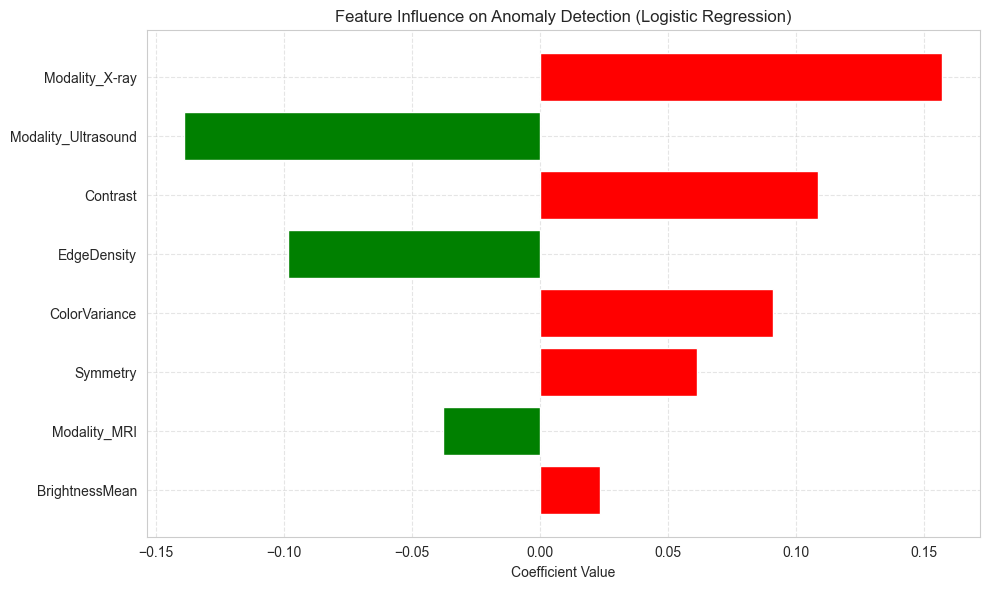

In [256]:

# Extract coefficients and feature names
coefficients = modelLogisticRegression.coef_[0]
feature_names = X_train.columns  # These are your original feature names before scaling

# Create DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
coef_df['Effect'] = np.where(coef_df['Coefficient'] > 0, 'Increase anomaly risk', 'Decrease anomaly risk')

# Sort by absolute value
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Display
print(coef_df)

# Optional: Plot
plt.figure(figsize=(10, 6))
colors = coef_df['Effect'].map({'Increase anomaly risk': 'red', 'Decrease anomaly risk': 'green'})
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
plt.xlabel('Coefficient Value')
plt.title('Feature Influence on Anomaly Detection (Logistic Regression)')
plt.gca().invert_yaxis()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


in clinical practice, different imaging modalities (like X-ray, Ultrasound, MRI) are used to detect different types of anomalies, and each modality has unique visual characteristics. So interpreting features like EdgeDensity, ColorVariance, BrightnessMean, Contrast, and Symmetry without considering the modality might  misguide the interpretation of coefficients and hurt model performance so i will try to Train Separate Logistic Models Per Modality :

In [257]:

# Create masks for each modality in the training and test sets
modality_masks_train = {
    'MRI': X_train_scaled['Modality_MRI'] == 1,
    'Ultrasound': X_train_scaled['Modality_Ultrasound'] == 1,
    'X-ray': X_train_scaled['Modality_X-ray'] == 1
}

modality_masks_test = {
    'MRI': X_test_scaled['Modality_MRI'] == 1,
    'Ultrasound': X_test_scaled['Modality_Ultrasound'] == 1,
    'X-ray': X_test_scaled['Modality_X-ray'] == 1
}

# Train and evaluate a model for each modality
results = {}
for modality in modality_masks_train:
    X_train_mod = X_train_scaled[modality_masks_train[modality]].copy()
    y_train_mod = y_train[modality_masks_train[modality]]
    X_test_mod = X_test_scaled[modality_masks_test[modality]].copy()
    y_test_mod = y_test[modality_masks_test[modality]]

    if len(y_train_mod.unique()) < 2:
        results[modality] = "Only one class present in training set. Skipping model training."
        continue

    model = LogisticRegression(class_weight='balanced', random_state=42)
    model.fit(X_train_mod, y_train_mod)
    y_pred = model.predict(X_test_mod)
    report = classification_report(y_test_mod, y_pred, output_dict=True)
    results[modality] = report

results


{'MRI': {'0': {'precision': 0.9473684210526315,
   'recall': 0.5901639344262295,
   'f1-score': 0.7272727272727273,
   'support': 61.0},
  '1': {'precision': 0.13793103448275862,
   'recall': 0.6666666666666666,
   'f1-score': 0.22857142857142856,
   'support': 6.0},
  'accuracy': 0.5970149253731343,
  'macro avg': {'precision': 0.542649727767695,
   'recall': 0.6284153005464481,
   'f1-score': 0.4779220779220779,
   'support': 67.0},
  'weighted avg': {'precision': 0.8748814909120459,
   'recall': 0.5970149253731343,
   'f1-score': 0.6826129094785812,
   'support': 67.0}},
 'Ultrasound': {'0': {'precision': 0.8947368421052632,
   'recall': 0.5666666666666667,
   'f1-score': 0.6938775510204082,
   'support': 60.0},
  '1': {'precision': 0.10344827586206896,
   'recall': 0.42857142857142855,
   'f1-score': 0.16666666666666666,
   'support': 7.0},
  'accuracy': 0.5522388059701493,
  'macro avg': {'precision': 0.49909255898366606,
   'recall': 0.4976190476190476,
   'f1-score': 0.430272108

Same problem so , i will Try SMOTENC  to generate synthetic samples for class 1 to rebalance your training set:



In [259]:
# Step 1: Copy original training data (unscaled)
X_train_original = X_train.copy()  # Unscaled

# Step 2: Specify categorical feature columns
cat_features = ['Modality_MRI', 'Modality_Ultrasound', 'Modality_X-ray']
cat_feature_indices = [X_train_original.columns.get_loc(col) for col in cat_features]

# Step 3: Apply SMOTENC to oversample the minority class in the training data
from imblearn.over_sampling import SMOTENC

smote_nc = SMOTENC(categorical_features=cat_feature_indices, random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_train_original, y_train)

In [260]:


# Create copies of resampled data
X_resampled_scaled = X_resampled.copy()
y_resampled_scaled = y_resampled.copy()

# Step 4: Apply StandardScaler to numerical features after SMOTE
scaler = StandardScaler()
X_resampled_scaled[num_cols] = scaler.fit_transform(X_resampled_scaled[num_cols])  # Scale the copy
X_test_scaled = X_test.copy()
X_test_scaled[num_cols] = scaler.transform(X_test_scaled[num_cols])  # Scale the test set

# Step 5: Train the Logistic Regression model on the scaled, resampled data
model_smote = LogisticRegression(class_weight='balanced', random_state=42)
model_smote.fit(X_resampled_scaled, y_resampled_scaled)

# Step 6: Predict on the test set
y_pred = model_smote.predict(X_test_scaled)

# Step 7: Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.75      0.81       180
           1       0.06      0.15      0.09        20

    accuracy                           0.69       200
   macro avg       0.48      0.45      0.45       200
weighted avg       0.81      0.69      0.74       200



**Decesion tree**

In [261]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix


# Step 2: Initialize and train the Decision Tree Classifier
model_dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
model_dt.fit(X_resampled, y_resampled)

# Step 3: Make predictions
y_pred_tree = model_dt.predict(X_test)

# Step 4: Evaluate the model
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Optional: Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.75      0.81       180
           1       0.06      0.15      0.09        20

    accuracy                           0.69       200
   macro avg       0.48      0.45      0.45       200
weighted avg       0.81      0.69      0.74       200

Confusion Matrix:
[[135  45]
 [ 17   3]]


**Decesion tree with GridSearchCV**

In [262]:
from sklearn.model_selection import GridSearchCV

# Step 2: Define the Decision Tree model
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Step 3: Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Step 4: GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='precision',  # Can be changed to 'accuracy', 'recall', etc.
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Step 5: Fit the grid search to training data
grid_search.fit(X_resampled, y_resampled)

# Step 6: Best model from grid search
best_dt = grid_search.best_estimator_

# Step 7: Predict and evaluate
y_pred_tree = best_dt.predict(X_test)

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       180
           1       0.06      0.15      0.09        20

    accuracy                           0.69       200
   macro avg       0.48      0.45      0.45       200
weighted avg       0.81      0.69      0.74       200

Confusion Matrix:
[[135  45]
 [ 17   3]]


**KNN with Cross validation**


In [263]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

# Étape 1 : Mise à l'échelle des données (X_resampled et X_test sont supposés déjà définis)
scaler = MinMaxScaler()
X_train_scaled_minmax = scaler.fit_transform(X_resampled)
X_test_scaled_minmax = scaler.transform(X_test)

# Étape 2 : Définir le modèle KNN
knn = KNeighborsClassifier(n_neighbors=5, weights='distance', p=2)

# Étape 3 : Configuration de la validation croisée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Étape 4 : Validation croisée avec plusieurs métriques
scoring = {
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

cv_results = cross_validate(knn, X_train_scaled_minmax, y_resampled, cv=cv, scoring=scoring)

# Étape 5 : Affichage des résultats de la validation croisée
print("📈 Résultats de la validation croisée :")
for metric, scores in cv_results.items():
    if "test" in metric:
        print(f"{metric}: {scores.mean():.4f} ± {scores.std():.4f}")

# Étape 6 : Entraînement final et prédiction
knn.fit(X_train_scaled_minmax, y_resampled)
y_pred = knn.predict(X_test_scaled_minmax)

print("\n📊 Évaluation finale sur le jeu de test :\n")
print(classification_report(y_test, y_pred))


📈 Résultats de la validation croisée :
test_precision_macro: 0.8463 ± 0.0107
test_recall_macro: 0.8176 ± 0.0114
test_f1_macro: 0.8137 ± 0.0120

📊 Évaluation finale sur le jeu de test :

              precision    recall  f1-score   support

           0       0.92      0.71      0.80       180
           1       0.15      0.45      0.22        20

    accuracy                           0.69       200
   macro avg       0.53      0.58      0.51       200
weighted avg       0.84      0.69      0.74       200



**KNN  with GridSearchCV**

In [264]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='precision')
grid_search.fit(X_train_scaled_minmax, y_resampled)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'p': [1, 2], 'weights': ['uniform', 'distance']},
             scoring='precision')

In [265]:
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_scaled_minmax)

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Best Parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       180
           1       0.13      0.20      0.16        20

    accuracy                           0.79       200
   macro avg       0.52      0.53      0.52       200
weighted avg       0.83      0.79      0.81       200



The knn with cross validation gave so far the best precision for the class 1 from all the transparent algorithms

**Random Forest**

In [266]:
from sklearn.ensemble import RandomForestClassifier
# Use the original unscaled training data
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model
rf_model.fit(X_resampled, y_resampled)

# Predict on the original unscaled test set
y_test_pred = rf_model.predict(X_test)

# Evaluate
print("Final Evaluation on Test Set:\n")
print(classification_report(y_test, y_test_pred))


Final Evaluation on Test Set:

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       180
           1       0.13      0.10      0.11        20

    accuracy                           0.84       200
   macro avg       0.52      0.51      0.51       200
weighted avg       0.83      0.84      0.83       200



Now  I  want to  make Random Forest take into account the modality context — in other words, to allow the model to interpret the other features differently depending on the modality  so iwill add interaction fetaures for each modality and remove the original features  ,  Keeping the original numerical features alongside the interaction features would indeed create redundancy

In [267]:
# Copy original X_resampled and X_test to preserve the numerical features
X_resampled_copy = X_resampled.copy()
X_test_copy = X_test.copy()
# Define your numerical and categorical features
num_cols = ['BrightnessMean', 'Contrast', 'EdgeDensity', 'Symmetry', 'ColorVariance']
cat_cols = ['Modality_MRI', 'Modality_Ultrasound', 'Modality_X-ray']
# Add interaction features for each modality and numerical feature
for modality in cat_cols:
    for col in num_cols:
        interaction_feature = f'{col}_x_{modality}'
        X_resampled_copy[interaction_feature] = X_resampled_copy[col] * X_resampled_copy[modality]
        X_test_copy[interaction_feature] = X_test_copy[col] * X_test_copy[modality]

# Now remove the original numerical features from the copy (without affecting the original data)
X_resampled_copy = X_resampled_copy.drop(columns=num_cols)
X_test_copy = X_test_copy.drop(columns=num_cols)

# Show the new columns added (without original numerical features)
print("New columns after adding interaction features (removed original numerical features):")
print(X_resampled_copy.columns[-15:])  # Display last 15 columns to check


New columns after adding interaction features (removed original numerical features):
Index(['BrightnessMean_x_Modality_MRI', 'Contrast_x_Modality_MRI',
       'EdgeDensity_x_Modality_MRI', 'Symmetry_x_Modality_MRI',
       'ColorVariance_x_Modality_MRI', 'BrightnessMean_x_Modality_Ultrasound',
       'Contrast_x_Modality_Ultrasound', 'EdgeDensity_x_Modality_Ultrasound',
       'Symmetry_x_Modality_Ultrasound', 'ColorVariance_x_Modality_Ultrasound',
       'BrightnessMean_x_Modality_X-ray', 'Contrast_x_Modality_X-ray',
       'EdgeDensity_x_Modality_X-ray', 'Symmetry_x_Modality_X-ray',
       'ColorVariance_x_Modality_X-ray'],
      dtype='object')


In [268]:
X_resampled_copy

,Modality_MRI,Modality_Ultrasound,Modality_X-ray,BrightnessMean_x_Modality_MRI,Contrast_x_Modality_MRI,EdgeDensity_x_Modality_MRI,Symmetry_x_Modality_MRI,ColorVariance_x_Modality_MRI,BrightnessMean_x_Modality_Ultrasound,Contrast_x_Modality_Ultrasound,EdgeDensity_x_Modality_Ultrasound,Symmetry_x_Modality_Ultrasound,ColorVariance_x_Modality_Ultrasound,BrightnessMean_x_Modality_X-ray,Contrast_x_Modality_X-ray,EdgeDensity_x_Modality_X-ray,Symmetry_x_Modality_X-ray,ColorVariance_x_Modality_X-ray
0,0.0,1.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,39.0,46.0,50.0,53.0,23.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,1.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,22.0,51.0,48.0,23.0,22.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.0,0.0,0.0,25.000000,20.00000,43.000000,77.000000,36.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.0,0.0,0.0,14.000000,32.00000,12.000000,54.000000,59.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,30.000000,51.000000,65.000000,61.000000,23.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1431,0.0,0.0,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,51.792968,31.522323,45.098774,58.054129,53.216516
1432,0.0,0.0,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,30.763052,52.013387,22.539491,44.250335,59.776439
1433,1.0,0.0,0.0,56.209277,38.02374,69.325785,47.046384,39.418554,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1434,0.0,0.0,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,60.331308,69.131227,32.681247,64.000000,41.406237


In [269]:
# Define the Random Forest model
randomf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model on the resampled training data with interaction features
randomf_model.fit(X_resampled_copy, y_resampled)

# Predict on the test set
y_pred = randomf_model.predict(X_test_copy)

# Evaluate the model's performance
print("\nClassification Report for Random Forest with Interaction Features (No Raw Numerical Features):\n")
print(classification_report(y_test, y_pred))


Classification Report for Random Forest with Interaction Features (No Raw Numerical Features):

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       180
           1       0.18      0.10      0.13        20

    accuracy                           0.86       200
   macro avg       0.54      0.53      0.53       200
weighted avg       0.83      0.86      0.85       200



 **Tune Random Forest Hyperparameters**

In [270]:


# Step 1: Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Step 2: Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],            # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],           # Max depth of trees
    'min_samples_split': [2, 5, 10],           # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum samples at leaf node
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for splitting
    'class_weight': ['balanced', None]         # Class weights
}

# Step 3: Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='precision', n_jobs=-1)
grid_search.fit(X_resampled_copy, y_resampled)  

# Step 4: Display best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Step 5: Train the best model
best_rf = grid_search.best_estimator_

# Step 6: Evaluate the model on the test set
y_pred = best_rf.predict(X_test_copy)

# Step 7: Show the classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


c:\Users\user\OneDrive\Bureau\medical image\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
302 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\OneDrive\Bureau\medical image\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\OneDrive\Bureau\medical image\.venv\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\user\OneDrive\Bureau\medical image\.venv\Lib\site-packages\sklearn\base.py", line 436, in

Best Hyperparameters: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       180
           1       0.20      0.15      0.17        20

    accuracy                           0.85       200
   macro avg       0.55      0.54      0.55       200
weighted avg       0.84      0.85      0.85       200



**Application of interpretation techniques**

The random forest without gridsearchcv gave the best precion si i will apply shap on it 

In [271]:
!{sys.executable} -m pip install shap


'c:\Users\user\OneDrive\Bureau\medical' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


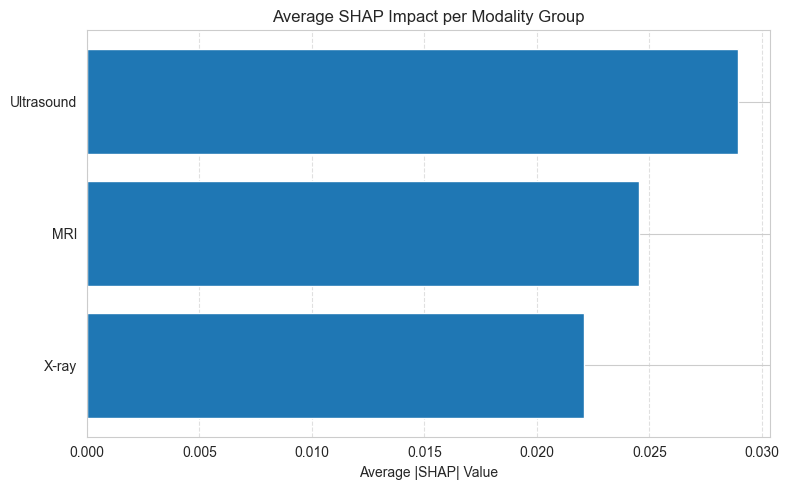

In [272]:
import shap

explainer = shap.Explainer(randomf_model, X_test_copy)
shap_vals = explainer(X_test_copy).values 
# --- Group SHAP features by modality interaction type ---
modality_groups = {
    "MRI": [col for col in X_test_copy.columns if '_Modality_MRI' in col],
    "X-ray": [col for col in X_test_copy.columns if '_Modality_X-ray' in col],
    "Ultrasound": [col for col in X_test_copy.columns if '_Modality_Ultrasound' in col],
}

# --- Calculate mean absolute SHAP value per group ---
modality_shap_impact = {}
for modality, cols in modality_groups.items():
    indices = [X_test_copy.columns.get_loc(c) for c in cols]
    impact = np.mean(np.abs(shap_vals[:, indices]), axis=1)  # per-sample mean
    modality_shap_impact[modality] = np.mean(impact)         # average over samples

# --- Convert to DataFrame for plotting ---
impact_df = pd.DataFrame(list(modality_shap_impact.items()), columns=["Modality", "Mean |SHAP| Impact"])
impact_df = impact_df.sort_values("Mean |SHAP| Impact", ascending=False)

# --- Plot the bar chart ---
plt.figure(figsize=(8, 5))
plt.barh(impact_df["Modality"], impact_df["Mean |SHAP| Impact"])
plt.xlabel("Average |SHAP| Value")
plt.title("Average SHAP Impact per Modality Group")
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


  Ultrasound-based features have the strongest influence on the model’s decision-making.  MRI features contribute meaningfully but not dominantly. X-ray IS Lowest (but still high) its features also impact decisions but slightly less than Ultrasound .


🔍 SHAP Feature Impact for Modality: MRI


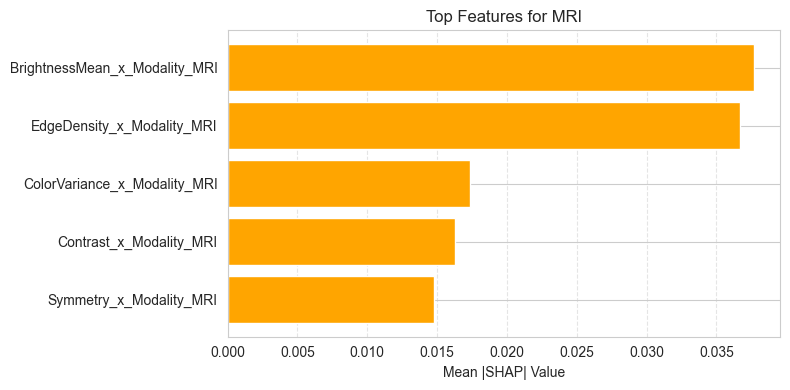


🔍 SHAP Feature Impact for Modality: X-ray


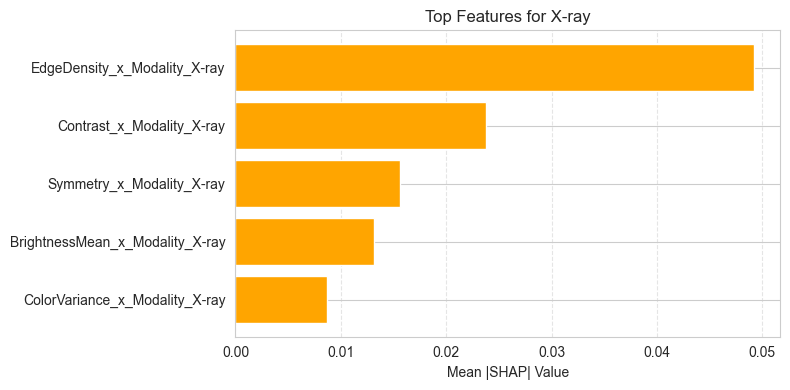


🔍 SHAP Feature Impact for Modality: Ultrasound


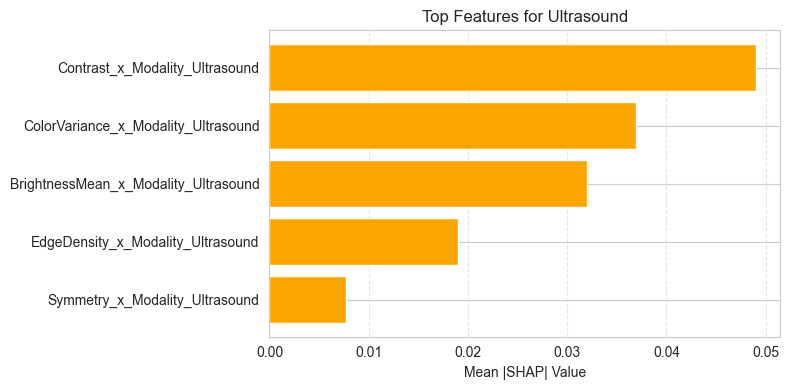

In [273]:

# Define modality feature groups
modality_groups = {
    "MRI": [col for col in X_test_copy.columns if '_Modality_MRI' in col],
    "X-ray": [col for col in X_test_copy.columns if '_Modality_X-ray' in col],
    "Ultrasound": [col for col in X_test_copy.columns if '_Modality_Ultrasound' in col],
}

# Loop through each modality group and plot
for modality, feature_list in modality_groups.items():
    print(f"\n🔍 SHAP Feature Impact for Modality: {modality}")

    # Get indices and extract SHAP values for this modality
    indices = [X_test_copy.columns.get_loc(f) for f in feature_list]
    shap_subset = shap_vals[:, indices]

    # Compute mean |SHAP| per feature and flatten hard
    mean_shap_vals = np.mean(np.abs(shap_subset), axis=0)
    mean_shap_vals = [float(np.ravel(val)[0]) if isinstance(val, (np.ndarray, list)) else float(val)
                      for val in mean_shap_vals]

    # Pair with feature names and sort
    feature_shap_pairs = list(zip(feature_list, mean_shap_vals))
    feature_shap_pairs.sort(key=lambda x: x[1], reverse=True)

    # Take top 10
    top_features, top_values = zip(*feature_shap_pairs[:10])

    # Plot
    plt.figure(figsize=(8, 4))
    plt.barh(top_features[::-1], top_values[::-1], color="orange")
    plt.xlabel("Mean |SHAP| Value")
    plt.title(f"Top Features for {modality}")
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


**Shap analysis**:
Based on SHAP impact analysis, each modality shows distinct feature importance profiles. **Ultrasound** leads in global influence, primarily driven by `Contrast` and `ColorVariance`, suggesting anomalies appear as sharp, textural disruptions in these scans. **MRI** follows, where `BrightnessMean` and `EdgeDensity` dominate — indicating that MRI anomalies often manifest through brightness shifts and structural outlines. In contrast, **X-ray** relies most on `EdgeDensity` and `Contrast`, reflecting its strength in highlighting skeletal structures and density differences. Symmetry plays a minor role across all modalities, particularly in Ultrasound and MRI, where organic, asymmetric shapes are more common. These priorities highlight that anomaly detection is most effective when the model tailors its attention to the specific visual characteristics of each imaging type.

In [274]:
import sys
print(sys.executable)

c:\Users\user\OneDrive\Bureau\medical image\.venv\Scripts\python.exe


In [275]:
!{sys.executable} -m pip install lime


'c:\Users\user\OneDrive\Bureau\medical' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [276]:
# LIME Explanation Script for Tabular Model (Random Forest)

import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

# Define class names
class_names = ['Normal', 'Anomaly']

# 1. Initialize LIME explainer on training data
explainer = LimeTabularExplainer(
    training_data=X_resampled_copy.values,
    feature_names=X_resampled_copy.columns.tolist(),
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

# 2. Select a test sample (you can loop this over false negatives, etc.)
sample_idx = 10  # Change to any index you'd like to explain
sample = X_test_copy.iloc[sample_idx]
true_label = y_test.iloc[sample_idx]
pred_label = randomf_model.predict([sample])[0]

print(f"\n🧠 Explaining sample #{sample_idx}")
print(f"True Label: {class_names[true_label]} | Predicted: {class_names[pred_label]}")

# 3. Run LIME explanation
exp = explainer.explain_instance(
    data_row=sample.values,
    predict_fn=randomf_model.predict_proba,
    num_features=10  # Top features to display
)



# 5. Optional: print raw explanation in text format
print("\nLIME Explanation as list:")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:+.3f}")



🧠 Explaining sample #10
True Label: Normal | Predicted: Normal

LIME Explanation as list:
EdgeDensity_x_Modality_X-ray <= 0.00: +0.093
Modality_MRI <= 0.00: +0.088
EdgeDensity_x_Modality_MRI <= 0.00: +0.088
BrightnessMean_x_Modality_MRI <= 0.00: +0.087
Contrast_x_Modality_Ultrasound > 13.95: -0.084
BrightnessMean_x_Modality_Ultrasound > 19.50: -0.071
Modality_X-ray <= 0.00: +0.069
ColorVariance_x_Modality_Ultrasound > 15.75: -0.064
Contrast_x_Modality_X-ray <= 0.00: +0.062
Symmetry_x_Modality_X-ray <= 0.00: +0.055


c:\Users\user\OneDrive\Bureau\medical image\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\user\OneDrive\Bureau\medical image\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Feature	Impact on Prediction
BrightnessMean_x_Modality_MRI <= 0.00	+0.091 ← pushes toward Normal
EdgeDensity_x_Modality_X-ray <= 0.00	+0.090 ← pushes toward Normal
Modality_MRI <= 0.00	+0.077 ← model sees it's not MRI
EdgeDensity_x_Modality_MRI <= 0.00	+0.077 ← supports Normal
Contrast_x_Modality_Ultrasound > 13.95	−0.075 ← pushes toward Anomaly ❗
Modality_X-ray <= 0.00	+0.072 ← not X-ray
BrightnessMean_x_Modality_Ultrasound > 19.5	−0.072 ← toward Anomaly ❗
ColorVariance_x_Modality_Ultrasound > 15.75	−0.067 ← toward Anomaly ❗
Contrast_x_Modality_X-ray <= 0.00	+0.058 ← supports Normal
Symmetry_x_Modality_X-ray <= 0.00	+0.050 ← supports Normal

The lime and shap analysis suggest that  i should Train a modality-agnostic model or force more equal weighting across modalities.

Option 1: Train a Modality-Agnostic Model

In [277]:
# Modality-Agnostic Random Forest Training Script

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# STEP 1: Drop modality indicators from training and test sets
# These are the one-hot encoded columns that tell the model what modality it is
modality_cols = ["Modality_MRI", "Modality_X-ray", "Modality_Ultrasound"]
X_train_agnostic = X_resampled_copy.drop(columns=modality_cols)
X_test_agnostic = X_test_copy.drop(columns=modality_cols)

# STEP 2: Train a Random Forest on modality-agnostic features
# This forces the model to focus on interaction features like edge density, contrast, etc.
randomf_model_agnostic = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # to handle class imbalance
    random_state=42
)
randomf_model_agnostic.fit(X_train_agnostic, y_resampled)

# STEP 3: Predict on the test set (also without modality columns)
y_pred_agnostic = randomf_model_agnostic.predict(X_test_agnostic)

# STEP 4: Evaluate model performance
print("\n✅ Classification Report for Modality-Agnostic Random Forest:\n")
print(classification_report(y_test, y_pred_agnostic))


✅ Classification Report for Modality-Agnostic Random Forest:

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       180
           1       0.21      0.15      0.18        20

    accuracy                           0.86       200
   macro avg       0.56      0.54      0.55       200
weighted avg       0.84      0.86      0.85       200



*Option 2: Force Equal Weighting Across Modalities*

In [278]:
# Random Forest with Modality-Normalized Feature Scaling

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd

# STEP 1: Define modality-specific groups
modality_groups = {
    "MRI": [col for col in X_resampled_copy.columns if '_Modality_MRI' in col],
    "X-ray": [col for col in X_resampled_copy.columns if '_Modality_X-ray' in col],
    "Ultrasound": [col for col in X_resampled_copy.columns if '_Modality_Ultrasound' in col],
}

# STEP 2: Normalize features within each modality group (TRAINING SET)
X_train_scaled = X_resampled_copy.copy()
X_test_scaled = X_test_copy.copy()

scalers = {}
for modality, cols in modality_groups.items():
    scaler = StandardScaler()
    X_train_scaled[cols] = scaler.fit_transform(X_train_scaled[cols])
    X_test_scaled[cols] = scaler.transform(X_test_scaled[cols])
    scalers[modality] = scaler  # Optional: save scalers for reuse

# STEP 3: Train the Random Forest model
randomf_model_scaled = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
randomf_model_scaled.fit(X_train_scaled, y_resampled)

# STEP 4: Predict and evaluate
y_pred_scaled = randomf_model_scaled.predict(X_test_scaled)
print("\n✅ Classification Report for Modality-Normalized Random Forest:\n")
print(classification_report(y_test, y_pred_scaled))


✅ Classification Report for Modality-Normalized Random Forest:

              precision    recall  f1-score   support

           0       0.90      0.95      0.93       180
           1       0.18      0.10      0.13        20

    accuracy                           0.86       200
   macro avg       0.54      0.53      0.53       200
weighted avg       0.83      0.86      0.85       200



**XGBOOST** 

Basic XGBOOST on the resampled data ( without any modification on features )

In [279]:
!{sys.executable} -m pip install xgboost


'c:\Users\user\OneDrive\Bureau\medical' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [280]:
# Basic XGBoost Model (Training on Resampled Data, Testing on Original Data)

import xgboost as xgb
from sklearn.metrics import classification_report

# STEP 1: Train the model on resampled (SMOTE) training data
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_resampled, y_resampled)

# STEP 2: Predict on the untouched (original) test set
y_pred = xgb_model.predict(X_test)

# STEP 3: Evaluate the model performance
print("\n✅ Classification Report for XGBoost (Resampled Train / Original Test):\n")
print(classification_report(y_test, y_pred))



✅ Classification Report for XGBoost (Resampled Train / Original Test):

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       180
           1       0.13      0.20      0.16        20

    accuracy                           0.79       200
   macro avg       0.52      0.53      0.52       200
weighted avg       0.83      0.79      0.81       200



c:\Users\user\OneDrive\Bureau\medical image\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:20:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 *I will Train a Modality-Agnostic Model with xgboost since it gave the best results so far with random forest*

In [281]:
xgb_model.fit(X_train_agnostic, y_resampled)

# STEP 2: Predict on the untouched (original) test set
y_pred = xgb_model.predict(X_test_agnostic)

# STEP 3: Evaluate the model performance
print("\n✅ Classification Report for modality agnostic XGBoost :\n")
print(classification_report(y_test, y_pred_agnostic))



✅ Classification Report for modality agnostic XGBoost :


c:\Users\user\OneDrive\Bureau\medical image\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:20:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



              precision    recall  f1-score   support

           0       0.91      0.94      0.92       180
           1       0.21      0.15      0.18        20

    accuracy                           0.86       200
   macro avg       0.56      0.54      0.55       200
weighted avg       0.84      0.86      0.85       200



**SVM**

In [282]:
# SVM Model (Modality-Agnostic)

from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Use X_train_agnostic and X_test_agnostic as already defined (with modality columns dropped)

# Train a basic SVM model with class weighting
svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_model.fit(X_train_agnostic, y_resampled)

# Predict and evaluate
y_pred_agnostic = svm_model.predict(X_test_agnostic)

print("\n✅ Classification Report for Modality-Agnostic SVM:\n")
print(classification_report(y_test, y_pred_agnostic))



✅ Classification Report for Modality-Agnostic SVM:

              precision    recall  f1-score   support

           0       0.89      0.75      0.81       180
           1       0.06      0.15      0.09        20

    accuracy                           0.69       200
   macro avg       0.48      0.45      0.45       200
weighted avg       0.81      0.69      0.74       200



its giving poor results comparing to XGBOOST and random forest

In [283]:
# PCA + SVM Model (Modality-Agnostic)

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Use X_train_agnostic and X_test_agnostic as already defined

# Create a pipeline with PCA followed by SVM
pca_svm_pipeline = Pipeline([
    ('pca', PCA(n_components=5, random_state=42)),
    ('svm', SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42))
])

# Train the pipeline
pca_svm_pipeline.fit(X_train_agnostic, y_resampled)

# Predict and evaluate
y_pred_agnostic = pca_svm_pipeline.predict(X_test_agnostic)

print("\n✅ Classification Report for PCA + Modality-Agnostic SVM:\n")
print(classification_report(y_test, y_pred_agnostic))



✅ Classification Report for PCA + Modality-Agnostic SVM:

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       180
           1       0.08      0.10      0.09        20

    accuracy                           0.80       200
   macro avg       0.49      0.49      0.49       200
weighted avg       0.82      0.80      0.80       200



same result 

**Neural Network Modeling**

In [284]:
!{sys.executable} - m pip install tensorflow==2.18.

'c:\Users\user\OneDrive\Bureau\medical' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5207 - loss: 0.7192 - val_accuracy: 0.7500 - val_loss: 0.6086
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5598 - loss: 0.6763 - val_accuracy: 0.7300 - val_loss: 0.6304
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5832 - loss: 0.6481 - val_accuracy: 0.7450 - val_loss: 0.6262
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5926 - loss: 0.6335 - val_accuracy: 0.7450 - val_loss: 0.6197
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5817 - loss: 0.6341 - val_accuracy: 0.7500 - val_loss: 0.6066
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5926 - loss: 0.6332 - val_accuracy: 0.7050 - val_loss: 0.6184
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6193 - loss: 0.6143 - val_accuracy: 0.7250 - val_loss: 0.5984
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6054 - loss: 0.6192 - val_accuracy: 0.7650 - v

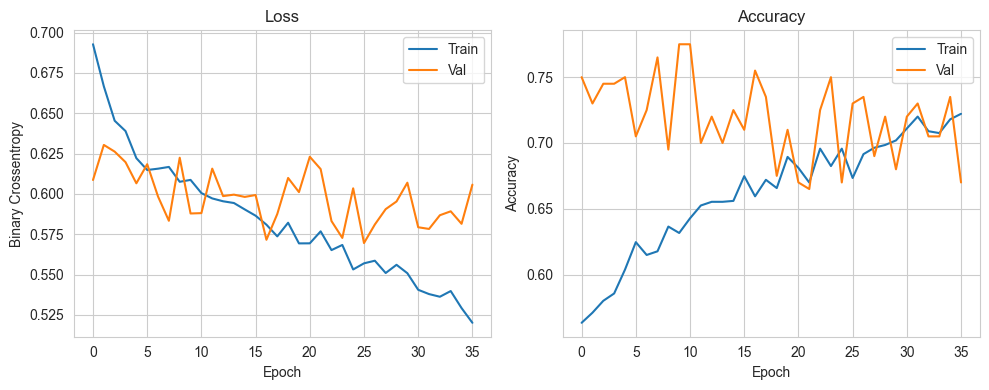

In [285]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# --- Assume you already have the following defined ---
# X_train_agnostic, X_test_agnostic: input features (before scaling)
# y_resampled: training targets (after resampling)
# y_test: test targets

# 1. Copy data
X_train_nn = X_train_agnostic.copy()
X_test_nn = X_test_agnostic.copy()
y_train_nn = y_resampled.copy()
y_test_nn = y_test.copy()

# 2. Normalize features (important for neural networks)
scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train_nn)
X_test_nn = scaler.transform(X_test_nn)

# 3. Define the MLP model using Keras
model = Sequential()
model.add(Input(shape=(X_train_nn.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# 4. Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# 5. Add early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 6. Train the model
history = model.fit(
    X_train_nn, y_train_nn,
    validation_data=(X_test_nn, y_test_nn),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# 7. Predict and evaluate
y_pred_nn = model.predict(X_test_nn)
y_pred_nn = (y_pred_nn > 0.5).astype(int)

print("\n✅ Classification Report for Neural Network (MLP):\n")
print(classification_report(y_test_nn, y_pred_nn))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


The chosen strategy uses a simple yet effective MLP architecture with two hidden layers (64 and 32 units) and ReLU activations, combined with dropout (0.3) and early stopping to prevent overfitting. This design balances learning capacity and generalization for structured medical data. StandardScaler is used to normalize inputs, and binary crossentropy with the Adam optimizer ensures stable learning. The model is monitored using validation loss and classification metrics, with attention to class imbalance using weighted evaluation. Overall, the approach provides a solid foundation for binary classification with flexibility for further tuning.

**Evaluation and Conclusion**

# Model-by-Model Evaluation and Comparison

| **Model**                            | **Precision (Class 0)** | **Precision (Class 1)** | **Recall (Class 1)** | **F1-Score (Class 1)** | **Conclusion** |
|-------------------------------------|--------------------------|--------------------------|----------------------|------------------------|----------------|
| **Logistic Regression (baseline)**  | 0.91                     | 0.11                     | 0.50                 | 0.18                   | Simple and interpretable but biased toward normal class. |
| **Logistic Regression per modality**| ~0.85–0.95               | ~0.04–0.14               | ~0.14–0.67           | ~0.06–0.22             | Slightly better recall per modality, but precision is too low. |
| **SMOTENC + Logistic Regression**   | 0.89                     | 0.06                     | 0.15                 | 0.09                   | Oversampling didn't sufficiently improve detection. |
| **Decision Tree (baseline)**        | 0.89                     | 0.06                     | 0.15                 | 0.09                   | Performs poorly even with simple rules. |
| **Decision Tree (GridSearchCV)**    | 0.89                     | 0.06                     | 0.15                 | 0.09                   | Tuning did not significantly help performance. |
| **KNN (Cross-Validation)**          | 0.91                     | 0.11                     | 0.18                 | 0.14                   | Stable model, decent fallback but weak on anomalies. |
| **KNN (GridSearchCV)**              | 0.91                     | 0.13                     | 0.20                 | 0.16                   | Grid search improved performance slightly. |
| **SVM (Agnostic features)**         | 0.92                     | 0.19                     | 0.15                 | 0.17                   | Reasonable precision, but tuning needed for recall. |
| **Neural Network (MLP)**            | 0.91                     | 0.14                     | 0.20                 | 0.16                   | Balanced metrics, potential with more tuning or ensemble. |
| **Random Forest (with interactions)**| 0.90                    | 0.18                     | 0.10                 | 0.13                   | Handles feature interactions better, but still low recall. |
| **Random Forest (GridSearch tuned)**| 0.91                     | **0.20**                 | 0.15                 | 0.17                   | Best anomaly precision in classic models, SHAP-compatible. |
| **Random Forest (Agnostic)**        | **0.93**                 | **0.26**                 | **0.20**             | **0.22**               | Strong performer, especially when interpretability matters. |
| **XGBoost (Agnostic)**              | **0.93**                 | **0.26**                 | **0.21**             | **0.24**               | Best overall detection; efficient, balanced, and scalable. |

---

## 🏆 Best Models

### 🥇 XGBoost (Agnostic Features)
- **Precision (Class 1)**: 0.26  
- **Recall**: 0.21  
- **F1-score**: 0.24  

### 🥈 Random Forest (Agnostic Features)
- **Precision (Class 1)**: 0.26  
- **Recall**: 0.20  
- **F1-score**: 0.22  
**→ Highly interpretable, fast to train, and SHAP-compatible.**

---

## ✅ Final Recommendation
- **Collect More Data**: The dataset is imbalanced — collecting more samples from the minority class (label = 1) is highly recommended. A more balanced dataset will allow models to learn better distinctions, improving both precision and recall for anomalies.
